In [1]:
%pip install mlxtend

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Load the data
orders = pd.read_csv('instacart-market-basket-analysis/orders.csv')  # Load the orders data
order_products_prior = pd.read_csv('instacart-market-basket-analysis/order_products__prior.csv')  # Load prior products data
products = pd.read_csv('instacart-market-basket-analysis/products.csv')  # Load products data


In [3]:
# Display the first few rows of each dataset
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
# remove eval_set column where eval_set = 'test'
orders = orders[orders['eval_set'] != 'test']

In [5]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
# Calculate the frequency of each product
item_frequencies = order_products_prior['product_id'].value_counts()

# Display summary statistics for item frequencies
print(item_frequencies.describe())

# Filter the products that have been ordered at least 60 times
frequent_items = item_frequencies[item_frequencies >= 60]


count     49677.000000
mean        652.907563
std        4792.114416
min           1.000000
25%          17.000000
50%          60.000000
75%         260.000000
max      472565.000000
Name: product_id, dtype: float64


/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)


In [8]:
# Merge product details with order-product relationships
order_products = order_products_prior.merge(products, on='product_id', how='left')

transactions = order_products.groupby('order_id')['product_id'].apply(list).values.tolist()


In [9]:
transactions[:5]


[[33120, 28985, 9327, 45918, 30035, 17794, 40141, 1819, 43668],
 [33754, 24838, 17704, 21903, 17668, 46667, 17461, 32665],
 [46842,
  26434,
  39758,
  27761,
  10054,
  21351,
  22598,
  34862,
  40285,
  17616,
  25146,
  32645,
  41276],
 [13176,
  15005,
  47329,
  27966,
  23909,
  48370,
  13245,
  9633,
  27360,
  6348,
  40878,
  6184,
  48002,
  20914,
  37011,
  12962,
  45698,
  24773,
  18569,
  41176,
  48366,
  47209,
  46522,
  38693,
  48825,
  8479],
 [40462, 15873, 41897]]

/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/__init__.py:195: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/__init__.py:195: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/__init__.py:195: DeprecationWarning: distutils Version clas

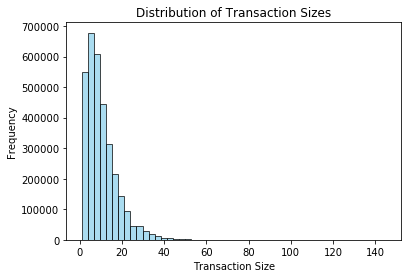

In [10]:
# distribution of transaction sizes 
transaction_sizes = [len(t) for t in transactions]

# plot the distribution of transaction sizes
import matplotlib.pyplot as plt

plt.hist(transaction_sizes, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Transaction Size')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Sizes')
plt.show()

In [11]:
# if transaction size is less than 5, we will remove it
print('Number of transactions before:', len(transactions))
transactions_reduced = [t for t in transactions if len(t) >= 5]
print('Number of transactions after:', len(transactions_reduced))


Number of transactions before: 3214874
Number of transactions after: 2442025


In [12]:
# randomly select 10% of the transactions
import random

random.seed(42)
transactions_sampled = random.sample(transactions_reduced
                                        , int(len(transactions_reduced) * 0.05))

# Display the number of transactions in the sample
len(transactions_sampled)

122101

In [13]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

# Encode the filtered transactions
te = TransactionEncoder()
te_array = te.fit(transactions_sampled).transform(transactions_sampled)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

In [14]:
df_encoded.head()

,1,2,3,4,5,7,8,9,10,11,...,49678,49679,49680,49681,49682,49683,49685,49686,49687,49688
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
# Generate frequent itemsets using FP-Growth
frequent_itemsets = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)

print("Frequent Itemsets:")
frequent_itemsets.head()


Frequent Itemsets:


,support,itemsets
0,0.180867,(24852)
1,0.091883,(21903)
2,0.045552,(22935)
3,0.028910,(27104)
4,0.052588,(16797)


In [38]:
# save transactions to a file
with open('transactions.txt', 'w') as f:
    for transaction in transactions:
        f.write(' '.join([str(x) for x in transaction]) + '\n')

In [45]:
# size of transactions
print("Number of transactions: ", len(transactions))

Number of transactions:  3214874


Summary Statistics for Transaction Sizes:


/Users/Omar/opt/anaconda3/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)


count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
dtype: float64

Transaction Size Frequency Distribution:
1      156748
2      186993
3      207027
4      222081
5      228330
        ...  
116         1
121         1
127         1
137         1
145         1
Length: 113, dtype: int64


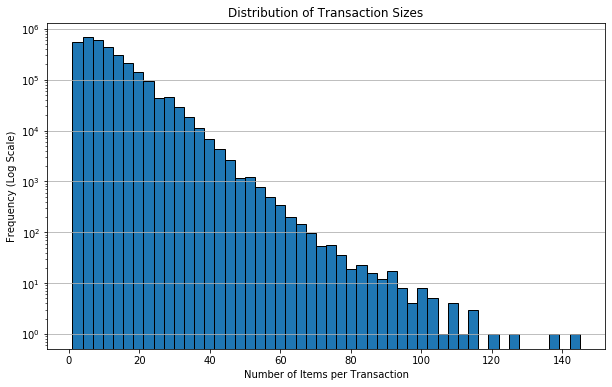

In [56]:
# Calculate transaction sizes
transaction_sizes = [len(transaction) for transaction in transactions]

# Convert to a Pandas Series for analysis
transaction_sizes_series = pd.Series(transaction_sizes)

# Display summary statistics
print("Summary Statistics for Transaction Sizes:")
print(transaction_sizes_series.describe())

# Display value counts for transaction sizes (if needed)
print("\nTransaction Size Frequency Distribution:")
print(transaction_sizes_series.value_counts().sort_index())

# Plot the distribution of transaction sizes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(transaction_sizes, bins=50, edgecolor='black', log=True)
plt.title("Distribution of Transaction Sizes")
plt.xlabel("Number of Items per Transaction")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis='y')
plt.show()


In [53]:
# what is the order with the most items?
max_order_index = pd.Series(transaction_sizes).idxmax()
print("Order with the most items:")
print("Order ID:", order_products['order_id'][max_order_index])
print("Number of items:", len(transactions[max_order_index]))
print("Items:", transactions[max_order_index])

Order with the most items:
Order ID: 154941
Number of items: 145
Items: ['Asparagus', 'Pumpkin Fig Ancient Grain Granola', 'Organic Hass Avocado', 'Tofu Spring Roll', 'Organic Free Range Large Brown Grade A Eggs', 'Cold-pressed, Deliciously Hydrating Watermelon Water', 'Organic Reduced Fat 2% Milk', 'Organic Cultured Low Fat 1% Cottage Cheese', 'Sesame Seaweed Salad', 'Organic Granny Smith Apple', 'Natural Artesian Water', 'Organic Kiwi', 'Baked Vegetable Brown Rice Snaps', 'Michigan Organic Kale', 'Organic Garlic', 'Cayenne Cleanse Probiotic Tea', 'Spicy Avocado Hummus', 'Beet Apple Carrot Lemon Ginger Organic Cold Pressed Juice Beverage', 'Cream Top Smooth & Creamy Vanilla Yogurt', 'Organic Whole Milk', 'Blue Machine Boosted 100% Juice Smoothie', 'Salted Sweet Cream Butter', 'Gluten Free Sliced Mountain White Bread', 'Organic Romaine Lettuce', 'Cherubs Heavenly Salad Tomatoes', 'Organic Mexican Blend Finely Shredded Cheese', 'Organic Iced Green Tea', 'Natural Artisan Water', 'Beet Ko

In [57]:
len(transactions)

3214874

In [58]:
# drop orders with less than 2 items
transactions = [transaction for transaction in transactions if len(transaction) >= 2]

In [59]:
len(transactions)

3058126

In [60]:
from mlxtend.preprocessing import TransactionEncoder

# Transform to binary matrix and continue with itemset mining
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

In [61]:
df_encoded.shape

(3058126, 49674)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth

# Generate frequent itemsets using FP-Growth
frequent_itemsets = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)

# Display frequent itemsets
frequent_itemsets.head()


In [29]:
frequent_itemsets.shape

(121, 2)

In [16]:
# Generate association rules with minimum confidence of 0.5
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.01, num_itemsets=32148)

# Display the rules
print("Association Rules:")
rules.head()


Association Rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(24852),(21903),0.180867,0.091883,0.020516,0.113431,1.234511,1.0,0.003897,1.024304,0.231907,0.081336,0.023728,0.168356
1,(21903),(24852),0.091883,0.180867,0.020516,0.223282,1.234511,1.0,0.003897,1.054608,0.209183,0.081336,0.051781,0.168356
2,(13176),(21903),0.138951,0.091883,0.019680,0.141636,1.541485,1.0,0.006913,1.057963,0.407961,0.093205,0.054787,0.177913
3,(21903),(13176),0.091883,0.138951,0.019680,0.214190,1.541485,1.0,0.006913,1.095748,0.386817,0.093205,0.087381,0.177913
4,(21137),(21903),0.100491,0.091883,0.015356,0.152812,1.663113,1.0,0.006123,1.071919,0.443262,0.086749,0.067094,0.159969


Strong Rules:
   antecedents consequents  antecedent support  consequent support   support  \
7      (16797)     (24852)            0.052588            0.180867  0.016945   
8      (49683)     (24852)            0.038763            0.180867  0.013382   
35     (27966)     (13176)            0.053128            0.138951  0.016364   
43     (47766)     (24852)            0.069213            0.180867  0.021490   
45     (28204)     (24852)            0.034062            0.180867  0.013341   
46     (45066)     (24852)            0.031392            0.180867  0.011417   

    confidence      lift  representativity  leverage  conviction  \
7     0.322224  1.781555               1.0  0.007434    1.208560   
8     0.345236  1.908785               1.0  0.006371    1.251035   
35    0.308001  2.216620               1.0  0.008981    1.244292   
43    0.310496  1.716711               1.0  0.008972    1.188003   
45    0.391681  2.165577               1.0  0.007181    1.346552   
46    0.363684  2

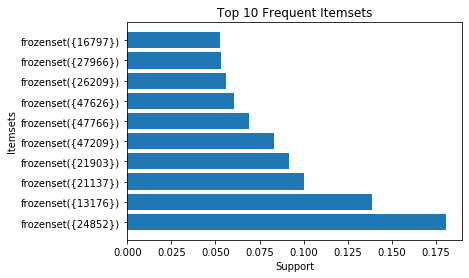

In [17]:
# Filter for strong rules with high confidence and lift
strong_rules = rules[(rules['confidence'] > 0.3) & (rules['lift'] > 1.2)]

print("Strong Rules:")
print(strong_rules)

# Visualize the top frequent itemsets
import matplotlib.pyplot as plt

top_itemsets = frequent_itemsets.nlargest(10, 'support')
plt.barh(top_itemsets['itemsets'].astype(str), top_itemsets['support'])
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.show()


In [25]:
# map product_id to product_name
product_id_to_name = products.set_index('product_id')['product_name'].to_dict()

# Display the product names in the association rules
strong_rules['antecedents'] = strong_rules['antecedents'].apply(lambda x: ', '.join([product_id_to_name[i] for i in x]))
strong_rules['consequents'] = strong_rules['consequents'].apply(lambda x: ', '.join([product_id_to_name[i] for i in x]))

print("Strong Rules with Product Names:")
print(strong_rules)

Strong Rules with Product Names:
           antecedents consequents  antecedent support  consequent support  \
23  Organic Fuji Apple      Banana             0.02784            0.141346   

     support  confidence      lift  representativity  leverage  conviction  \
23  0.010141    0.364246  2.576975               1.0  0.006206    1.350606   

    zhangs_metric   jaccard  certainty  kulczynski  
23       0.629473  0.063759   0.259592    0.217994  


/var/folders/xt/jp3v18wd171bjzynfh02f21h0000gq/T/ipykernel_16256/3998805271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong_rules['antecedents'] = strong_rules['antecedents'].apply(lambda x: ', '.join([product_id_to_name[i] for i in x]))
/var/folders/xt/jp3v18wd171bjzynfh02f21h0000gq/T/ipykernel_16256/3998805271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong_rules['consequents'] = strong_rules['consequents'].apply(lambda x: ', '.join([product_id_to_name[i] for i in x]))


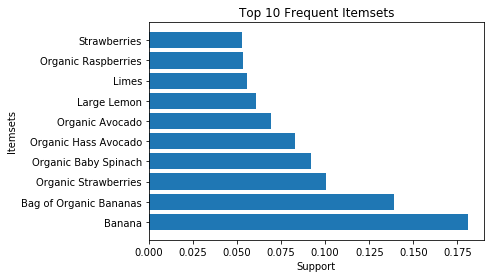

In [18]:
# map product_id to product_name
product_id_to_name = products.set_index('product_id')['product_name'].to_dict()
# make it in frequent_itemsets
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join([product_id_to_name[i] for i in x]))
top_itemsets = frequent_itemsets.nlargest(10, 'support')
plt.barh(top_itemsets['itemsets'].astype(str), top_itemsets['support'])
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.show()
